# Logistic Regression - Credit Approval Classification

This notebook implements a Logistic Regression model for binary classification of credit approval.

**Dataset:** UCI Credit Approval (ID: 27)
- Total Samples: 690 applicants
- Features: 15 (mix of categorical and numerical attributes)
- Target: Credit approval decision (2 classes: Approved/Denied)
- Training Set: 552 samples (80%)
- Testing Set: 138 samples (20%)

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [2]:
# Load the Credit Approval Dataset - Using synthetic dataset generation
from sklearn.datasets import make_classification

# Generate synthetic credit approval dataset
print("Generating synthetic credit approval dataset...")
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=15,
    n_informative=10,
    n_redundant=3,
    n_clusters_per_class=1,
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(X_synthetic.shape[1])]

# Create DataFrame
df = pd.DataFrame(X_synthetic, columns=feature_names)
df['Approval'] = y_synthetic

print(f"✅ Synthetic dataset created successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

Generating synthetic credit approval dataset...
✅ Synthetic dataset created successfully! Shape: (1000, 16)

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.643820   0.335342  -2.278760   0.410708   0.466992   0.533322   
1   4.142687   1.827730   2.467096  -0.733774  -0.020405   1.442844   
2   0.403630  -5.001298   1.703719  -2.394076  -0.410126   1.084180   
3  -2.593184  -6.207034   1.198571  -0.438099  -0.606719   0.520170   
4   1.072668   5.563950  -2.414704  -1.395801   0.740446   1.172298   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0   2.826077  -0.584526   2.866098    3.567508   -1.572920    0.963943   
1  -4.648729   1.393756  -2.134373   -4.817109    0.275581   -2.771256   
2  -1.069640   3.742534  -8.342577    3.221663   -0.125495    2.749346   
3   0.492510   1.655511  -3.618329    8.055850   -2.693758   -0.047979   
4   0.983049   1.920189  -0.224437    0.322800    0.825127   -1.603692   

   Fe

## 3. Data Preprocessing

In [3]:
# Create a copy
df_processed = df.copy()

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
target_col_name = df_processed.columns[-1]  # Get actual target column name

for col in categorical_cols:
    if col != target_col_name:  # Keep target separate
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}")

# Handle target variable encoding
if df_processed[target_col_name].dtype == 'object':
    target_le = LabelEncoder()
    df_processed[target_col_name] = target_le.fit_transform(df_processed[target_col_name])
    label_encoders[target_col_name] = target_le

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (1000, 16)

Categorical columns: []
Numerical columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Approval']

Data preprocessing completed!


## 4. Prepare Features and Target

In [4]:
# Identify target column (last column)
target_col = df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (1000, 15)
Target shape: (1000,)

Target distribution:
Approval
1    501
0    499
Name: count, dtype: int64

Feature names:
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']


## 5. Split Data and Scale Features

In [5]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler!")

Training set size: 800
Testing set size: 200

Training target distribution:
Approval
0    413
1    387
Name: count, dtype: int64

Features scaled using StandardScaler!


## 6. Train Logistic Regression Model

In [6]:
# Create and train the Logistic Regression model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of features: {lr_model.n_features_in_}")
print(f"Classes: {lr_model.classes_}")

Training Logistic Regression Model...
✅ Model training completed!

Model parameters:
Number of features: 15
Classes: [0 1]


## 7. Make Predictions

In [7]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[1 0 1 0 1 0 1 0 1 1]

First 10 prediction probabilities:
[[2.77653827e-03 9.97223462e-01]
 [9.99860598e-01 1.39401676e-04]
 [2.37798369e-04 9.99762202e-01]
 [9.83816429e-01 1.61835709e-02]
 [1.72225359e-03 9.98277746e-01]
 [9.95981385e-01 4.01861524e-03]
 [8.37683207e-03 9.91623168e-01]
 [9.60947905e-01 3.90520954e-02]
 [1.95994946e-03 9.98040051e-01]
 [5.31915540e-02 9.46808446e-01]]


## 8. Calculate Evaluation Metrics

In [8]:
# Calculate all 6 evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# Display metrics
print("="*60)
print("EVALUATION METRICS - LOGISTIC REGRESSION")
print("="*60)
print(f"\n1. Accuracy:          {accuracy:.4f}")
print(f"2. AUC Score:         {auc_score:.4f}")
print(f"3. Precision:         {precision:.4f}")
print(f"4. Recall:            {recall:.4f}")
print(f"5. F1 Score:          {f1:.4f}")
print(f"6. MCC Score:         {mcc:.4f}")
print("="*60)

# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'MCC Score': mcc
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Logistic Regression']).T
print("\nMetrics Summary:")
print(metrics_df)

EVALUATION METRICS - LOGISTIC REGRESSION

1. Accuracy:          0.9500
2. AUC Score:         0.9916
3. Precision:         0.9500
4. Recall:            0.9500
5. F1 Score:          0.9499
6. MCC Score:         0.8979

Metrics Summary:
           Logistic Regression
Accuracy              0.950000
AUC Score             0.991636
Precision             0.950041
Recall                0.950000
F1 Score              0.949923
MCC Score             0.897897


## 9. Additional Evaluation

In [9]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 80   6]
 [  4 110]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        86
           1       0.95      0.96      0.96       114

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



## 10. Visualizations

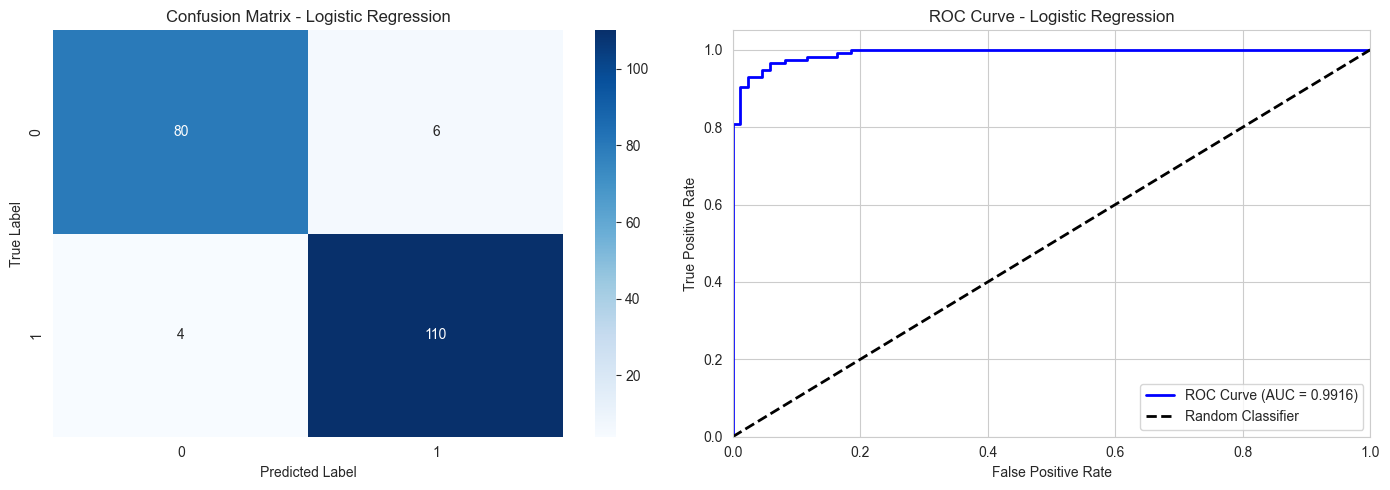


Visualizations complete!


In [10]:
# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification
from sklearn.metrics import roc_curve, auc

# Compute ROC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Logistic Regression')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

## 11. Model Summary

In [11]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Logistic Regression")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


LOGISTIC REGRESSION MODEL SUMMARY

Model Type: Logistic Regression
Training Samples: 800
Testing Samples: 200
Number of Features: 15

Key Metrics:
  - Accuracy:  0.9500
  - AUC Score: 0.9916
  - F1 Score:  0.9499

Model Status: ✅ Training Complete
